In [55]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro

import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

## (1) Load dataset

In [8]:
df = pd.read_csv("data/gene_data_train.csv")
print(df.shape)
df.head()

(1000, 16)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
0,2.442848,1.687888,0.469727,2.036935,0.338513,1.296362,2.295771,0.363421,-0.106631,1.407895,0.596148,0.358668,0.497722,1.165225,0.841043,0.203415
1,3.334706,1.480571,0.885413,2.340743,0.626904,2.188196,1.915579,1.242122,0.756687,1.649212,0.724354,0.210039,1.273396,1.383854,1.167070,0.010035
2,-0.403231,-0.448922,0.013330,0.912262,0.104885,-0.127585,-0.718686,-1.264042,0.966555,0.590284,0.471497,-0.237898,-0.028427,0.999798,-0.063783,-0.251955
3,2.924908,1.871368,0.717134,2.553759,0.461372,1.823811,2.409575,0.886211,0.180740,1.166210,0.622089,0.182978,0.745579,1.248753,1.089831,-0.462595
4,4.074106,2.434649,1.047314,2.398894,0.751044,2.761664,3.423753,1.352372,0.564267,1.572461,0.748105,0.983673,1.465964,1.430766,1.277524,0.757766


In [65]:
nodes = df.columns.values
print(nodes)

['X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'X9' 'X10' 'X11' 'X12' 'X13'
 'X14' 'X15' 'X16']


## (2) BN structure

- **Learn bn structure using bnlearn**

In [45]:
# Import r package
pandas2ri.activate()
bnlearn = importr("bnlearn")

# Hill climbing algorithm
bn_r = bnlearn.hc(df)  # optional arguments: restart , perturb 

# Convert R object to Python dictionary
bn_pd = ro.conversion.rpy2py(bn_r)
bn = dict(zip(bn_pd.names, map(list,list(bn_pd))))

# Extract edges
edges = bn['arcs']
edges = (np.asmatrix(edges).reshape(2,-1)).T.tolist()
print(f"Number of edges: {len(edges)}")   

Number of edges: 19


- **Create DiGraph objects**

In [46]:
# Learned structure (the structure learned from data)
learn_g = nx.DiGraph()
learn_g.add_nodes_from(nodes)
learn_g.add_edges_from(edges)

# True structure (the structure used to generate data)
true_network_edges = pd.read_csv("data/gene_edges.csv")
ture_g = nx.DiGraph()
ture_g.add_nodes_from(nodes)
ture_g.add_edges_from(np.array(true_network_edges))

- **Compare learned strucutre with true structure**

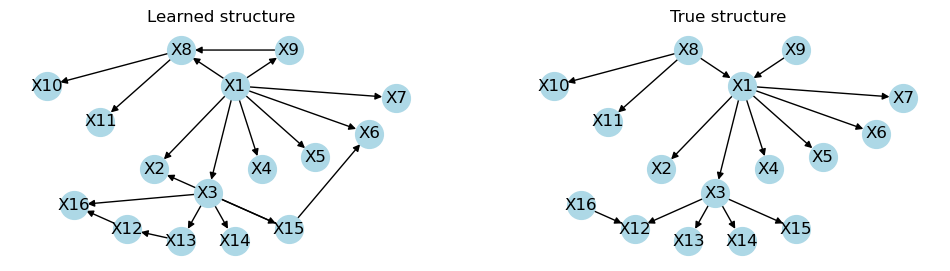

In [47]:
custom_pos ={'X1':[0.5, 0.8],'X2':[0.35, 0.45],'X3':[0.45, 0.35],'X4':[0.55, 0.45],'X5':[0.65, 0.5],'X6':[0.75, 0.6],'X7':[0.8, 0.75],'X8':[0.4, 0.95],
        'X9':[0.6, 0.95],'X10':[0.15, 0.8],'X11':[0.25, 0.65],'X12':[0.3, 0.2],'X13':[0.4, 0.15],'X14':[0.5, 0.15],'X15':[0.6, 0.2],'X16':[0.2, 0.3]}

fig, ax = plt.subplots(1, 2, figsize = (12, 3))
nx.draw(learn_g, custom_pos, with_labels = True, node_color='lightblue', node_size = 400, ax = ax[0])
nx.draw(ture_g, custom_pos, with_labels = True, node_color='lightblue', node_size = 400, ax = ax[1])

ax[0].set_title("Learned structure")
ax[1].set_title("True structure");

## (3) Likelihood 

In [96]:
from sklearn import linear_model
import math

In [62]:
def lik_score(data, target_name, parents_name):
    n = len(data)
    target = data[target_name]
    
    if len(parents_name)==0:
        resid = target
    else:
        parents = data[parents_name]     
        lm = linear_model.LinearRegression()
        lm.fit(parents,target)
        pred = lm.predict(parents)
        resid = target-pred
            
    resid_m = np.mean(resid)
    resid_s = np.var(resid)
    
    ln_lik = -(n/2)*np.log(2*math.pi) - (n/2)*np.log(resid_s) - (1/(2*resid_s))*(sum((resid-resid_m)**2))
    
    return ln_lik
    

- **Local likelihood**

In [71]:
# Root node 
parents_name = [pa for pa in ture_g.predecessors("X9")]
print(f"Number of parents of X9: {len(parents_name)}")
local_lik = lik_score(data = df, target_name = "X9", parents_name = parents_name)
print(f"Local likelihood of X9: {local_lik:.2f}")

Number of parents of X9: 0
Local likelihood of X9: -1417.73


In [72]:
# Non-root node
parents_name = [pa for pa in ture_g.predecessors("X1")]
print(f"Number of parents of X1: {len(parents_name)}")
local_lik = lik_score(data = df, target_name = "X1", parents_name = parents_name)
print(f"Local likelihood of X1: {local_lik:.2f}")

Number of parents of X1: 2
Local likelihood of X1: -666.89


- **Global likelihood**

In [73]:
gb_lik = 0
for node in nodes:
    parents_name = [pa for pa in ture_g.predecessors(node)]
    local_lik = lik_score(data = df, target_name = node, parents_name = parents_name)
    gb_lik += local_lik

print(f"Global likelihood: {gb_lik:.2f}")

Global likelihood: 1724.82
